In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
dup_chr, dup_start, dup_end = "chr02", 28000000, 32000000
# depth_filter = 0.05
# min_depth_norm = 1.

In [4]:
df_repeats, df_calls_hs = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/v0.9.0/SAMEA5752290_HiSeq1500_chr2_dup.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

df_calls_hs = df_calls_hs.dropna().merge(
    df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id"
    ).assign(
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
        depth_norm = lambda x: x["depth"] / x["copy_number"],
        in_dup = lambda x: np.array((x["chr"] == dup_chr) & (x["start"] > dup_start) & (x["end"] < dup_end))
    ).reset_index(drop=True)

df_calls_hs = df_calls_hs.rename(columns={
    "frequencies": "frequencies_hs", 
    "genotype": "genotype_hs",
})

df_repeats.shape, df_calls_hs.shape

((183345, 7), (148728, 12))

In [5]:
print(df_calls_hs.shape)
lower_hs, upper_hs = 1.0, 17.0
df_calls_filt_hs = df_calls_hs.query(f"depth_norm >= {lower_hs} and depth_norm <= {upper_hs}").reset_index(drop=True)
print(df_calls_filt_hs.shape)

(148728, 12)
(144657, 12)


In [6]:
df_repeats, df_calls_ns = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/v0.9.0/SAMEA5752290_NextSeq500_chr2_dup.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

df_calls_ns = df_calls_ns.dropna().merge(
    df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id"
    ).assign(
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
        depth_norm = lambda x: x["depth"] / x["copy_number"],
        in_dup = lambda x: np.array((x["chr"] == dup_chr) & (x["start"] > dup_start) & (x["end"] < dup_end))
    ).reset_index(drop=True)

df_calls_ns = df_calls_ns.rename(columns={
    "frequencies": "frequencies_ns", 
    "genotype": "genotype_ns",
})

df_repeats.shape, df_calls_ns.shape

((183345, 7), (144597, 12))

In [7]:
print(df_calls_ns.shape)
lower_ns, upper_ns = 1.0, 19.0
df_calls_filt_ns = df_calls_ns.query(f"depth_norm >= {lower_ns} and depth_norm <= {upper_ns}").reset_index(drop=True)
print(df_calls_filt_ns.shape)

(144597, 12)
(140746, 12)


In [8]:
df_calls_filt_ns

,sample,str_id,copy_number,frequencies_ns,genotype_ns,chr,start,end,period,depth,depth_norm,in_dup
0,SAMEA5752290,chr01_22744,3,{3: 12},"[3, 3, 3]",chr01,22744,22755,4,12,4.000000,False
1,SAMEA5752290,chr01_33907,3,{3: 26},"[3, 3, 3]",chr01,33907,33924,6,26,8.666667,False
2,SAMEA5752290,chr01_35829,3,"{5: 6, 6: 4}","[5, 5, 6]",chr01,35829,35842,2,10,3.333333,False
3,SAMEA5752290,chr01_37997,3,{7: 4},"[7, 7, 7]",chr01,37997,38046,2,4,1.333333,False
4,SAMEA5752290,chr01_38113,3,{6: 7},"[6, 6, 6]",chr01,38113,38124,2,7,2.333333,False
...,...,...,...,...,...,...,...,...,...,...,...,...
140741,SAMEA5752290,chr11_34593028,3,{3: 39},"[3, 3, 3]",chr11,34593028,34593039,4,39,13.000000,False
140742,SAMEA5752290,chr11_34594761,3,"{10: 34, 11: 14, 12: 1}","[10, 10, 11]",chr11,34594761,34594770,1,49,16.333333,False
140743,SAMEA5752290,chr11_34602888,3,{0: 6},"[0, 0, 0]",chr11,34602888,34602900,1,6,2.000000,False
140744,SAMEA5752290,chr11_34616355,3,{2: 3},"[2, 2, 2]",chr11,34616355,34616372,6,3,1.000000,False


In [9]:
mask_ns = ((df_calls_filt_ns["period"] <= 2) & (df_calls_filt_ns["depth_norm"] < 1.))
mask_hs = ((df_calls_filt_hs["period"] <= 2) & (df_calls_filt_hs["depth_norm"] < 1.))

df_calls_merge = (df_calls_filt_ns[["str_id", "period", "frequencies_ns", "genotype_ns"]]
                 .merge(df_calls_filt_hs[["str_id", "frequencies_hs", "genotype_hs", "in_dup"]], on="str_id")
                 .assign(match = lambda x: x["genotype_ns"] == x["genotype_hs"]))

df_calls_merge

,str_id,period,frequencies_ns,genotype_ns,frequencies_hs,genotype_hs,in_dup,match
0,chr01_22744,4,{3: 12},"[3, 3, 3]",{3: 10},"[3, 3, 3]",False,True
1,chr01_35829,2,"{5: 6, 6: 4}","[5, 5, 6]",{5: 9},"[5, 5, 5]",False,False
2,chr01_37997,2,{7: 4},"[7, 7, 7]",{7: 4},"[7, 7, 7]",False,True
3,chr01_38113,2,{6: 7},"[6, 6, 6]",{6: 11},"[6, 6, 6]",False,True
4,chr01_40758,1,"{11: 29, 12: 1, 13: 6, 14: 1}","[11, 11, 13]","{11: 24, 12: 3, 13: 7, 14: 1}","[11, 11, 13]",False,True
...,...,...,...,...,...,...,...,...
133421,chr11_34585131,2,"{6: 18, 8: 11}","[6, 6, 8]","{6: 26, 8: 12}","[6, 6, 8]",False,True
133422,chr11_34585501,1,"{9: 1, 10: 29, 11: 1, 12: 11}","[10, 10, 12]","{9: 1, 10: 20, 12: 13, 13: 1}","[10, 10, 12]",False,True
133423,chr11_34588059,1,"{9: 14, 10: 28, 11: 2}","[9, 10, 10]","{9: 19, 10: 24}","[9, 10, 10]",False,True
133424,chr11_34593028,4,{3: 39},"[3, 3, 3]",{3: 47},"[3, 3, 3]",False,True


In [10]:
print(df_calls_merge["match"].value_counts())
df_calls_merge["match"].value_counts(normalize=True)

match
True     109190
False     24236
Name: count, dtype: int64


match
True     0.818356
False    0.181644
Name: proportion, dtype: float64

In [11]:
(df_calls_merge
    .groupby(["period"], as_index=False)
    .value_counts(["match"], normalize=False))

,period,match,count
0,1,True,30851
1,1,False,10677
2,2,True,15982
3,2,False,9122
4,3,True,30525
5,3,False,2884
6,4,True,22790
7,4,False,823
8,5,True,5874
9,5,False,398


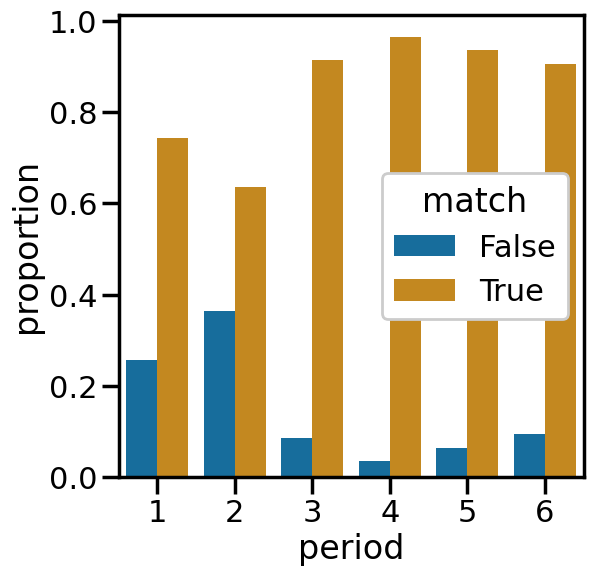

In [12]:
fig = plt.figure(figsize=(6, 6))

df_plot = (df_calls_merge
    .groupby(["period"], as_index=False)
    .value_counts(["match"], normalize=True))

ax = sns.barplot(
    df_plot,
    x="period",
    y="proportion",
    hue="match",
    palette="colorblind"
)

sns.move_legend(ax, "center right")
ax.get_legend().get_frame().set_alpha(1.)

In [13]:
thresholds = [1., 5., 10., 15.]

df_plot = []
for thresh in thresholds:
    df = (df_calls_filt_ns.query(f"depth_norm >= {thresh}")[["str_id", "period", "frequencies_ns", "genotype_ns"]]
             .merge(df_calls_filt_hs.query(f"depth_norm >= {thresh}")[["str_id", "frequencies_hs", "genotype_hs", "in_dup"]], on="str_id")
             .assign(match = lambda x: x["genotype_ns"] == x["genotype_hs"]))
    
    df = df.groupby(["period"], as_index=False).value_counts(["match"], normalize=True).query("match == True")[["period", "proportion"]]
    df_plot.append(df.assign(threshold = thresh))

df_plot = pd.concat(df_plot)

In [14]:
df_plot.pivot(index="period", columns='threshold', values='proportion')

threshold,1.0,5.0,10.0,15.0
period,,,,
1,0.742896,0.800767,0.874020,0.934435
2,0.636632,0.717618,0.866640,0.933962
3,0.913676,0.926278,0.964056,0.983359
4,0.965146,0.966896,0.983901,0.995526
5,0.936543,0.941116,0.968208,0.980519
6,0.905143,0.918083,0.961012,0.975000


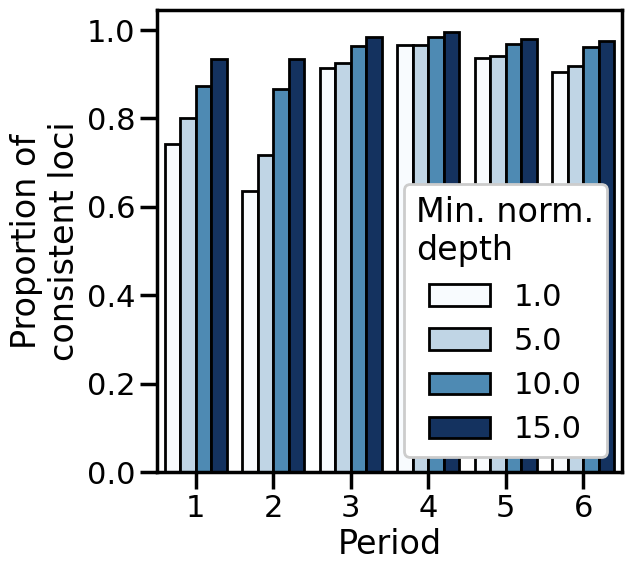

In [32]:
fig = plt.figure(figsize=(6, 6))

palette = [
    sns.color_palette("Blues")[0],
    sns.color_palette("Blues")[2],
    sns.color_palette("Blues")[3],
    sns.color_palette("colorblind")[0],
]

ax = sns.barplot(
    df_plot,
    x="period",
    y="proportion",
    hue="threshold",
    # palette=palette,
    palette="Blues",
    edgecolor="black",
)

_ = ax.set(
    xlabel="Period",
    ylabel="Proportion of\nconsistent loci",
)

sns.move_legend(ax, "lower right")
ax.get_legend().get_frame().set_alpha(1.)
_ = ax.get_legend().set(title="Min. norm.\ndepth")